In [1]:
# # header
import sys
sys.path.append(r"../")

%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
from src.model import AttentionModel
from src.composer import PsychCompare
from src.conductor import seq_cls_eval
from src.utils import plot_all, build_loaders, sigmoid, fit_sigmoid
from prelude import get_device, startup_folders, load_dicts
import matplotlib.pyplot as plt

In [3]:
start_folder = r"../pretrained/psycphys/compare/"
results_folder, logger = startup_folders(start_folder, name=f"exp_a")
data_path = r"../data"

../pretrained/psycphys/compare/1753273554 was created!


In [4]:
model_params = load_dicts(start_folder, "model_params")
tasks = load_dicts(start_folder, "tasks")
train_params = load_dicts(start_folder, "train_params")
DeVice, num_workers, pin_memory = get_device()
print(f"model_params: {model_params}")
print(f"tasks: {tasks}")
print(f"train_params: {train_params}")
train_params["batch_size"] = 256
tasks

Device set to mps
model_params: {'in_dims': [1, 96, 96], 'n_classes': 9, 'out_dim': 9, 'normalize': True, 'softness': 0.5, 'channels': [1, 4, 8, 16, 32, 32], 'residuals': False, 'kernels': 3, 'strides': 2, 'paddings': 1, 'conv_bias': True, 'conv_norms': [None, 'layer', 'layer', 'layer', 'layer'], 'conv_dropouts': 0.0, 'conv_funs': ReLU(), 'deconv_funs': Tanh(), 'deconv_norms': [None, 'layer', 'layer', 'layer', 'layer'], 'pools': [1, 1, 1, 1, 1], 'rnn_dims': [16], 'rnn_bias': True, 'rnn_dropouts': 0.0, 'rnn_funs': ReLU(), 'n_tasks': 1, 'task_layers': 1, 'task_weight': True, 'task_bias': True, 'task_funs': Tanh(), 'norm_mean': [0.5], 'norm_std': [0.25], 'rnn_to_fc': False, 'trans_fun': Identity()}
tasks: {'RotationChangeDetection': {'composer': 'PsychCompare', 'key': 0, 'params': {'episodes': [0, 2, 0, 2], 'a_range': [0.2, 0.8], 'n_range': [0.0, 0.2], 'b_range': [0.125, 0.25], 'd_range': [0.0, 0.2], 'biased': 0.0, 'force_range': False, 'force_label': False, 'force_cue': False, 'force_loc

{'RotationChangeDetection': {'composer': 'PsychCompare',
  'key': 0,
  'params': {'episodes': [0, 2, 0, 2],
   'a_range': [0.2, 0.8],
   'n_range': [0.0, 0.2],
   'b_range': [0.125, 0.25],
   'd_range': [0.0, 0.2],
   'biased': 0.0,
   'force_range': False,
   'force_label': False,
   'force_cue': False,
   'force_loc': False},
  'datasets': ['PsychCompare', 'PsychCompare', 'PsychCompare'],
  'dataloaders': [None, None, None],
  'loss_w': [[1.0, 1.0], [1.0, 1.0]],
  'loss_s': [[-2, -1], [-4, -3]]}}

In [5]:
# datasets and dataloaders
o = "RotationChangeDetection"
tasks[o]["composer"] = PsychCompare
tasks[o]["datasets"] = []
tasks[o]["dataloaders"] = []

# datasets and dataloaders
for o in tasks:
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"], n_samples=train_params["n_samples"]))
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"], n_samples=1024))
    tasks[o]["datasets"].append(tasks[o]["composer"](**tasks[o]["params"], n_samples=1024))
    tasks[o]["dataloaders"] = build_loaders(tasks[o]["datasets"], batch_size=train_params["batch_size"], num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

# create a blank model
model = AttentionModel(**model_params)

# load states into the model
model_dir = os.path.join(start_folder, "model" + ".pth")
assert os.path.exists(model_dir), "Could not find the model.pth in the given dir!"
model.load_state_dict(torch.load(model_dir, map_location=DeVice))

<All keys matched successfully>

In [6]:
ce_loss, accuracy, mask_loss = seq_cls_eval(model, tasks, DeVice, logger, valid=True, verbose=True)
print(f"CE Loss: {ce_loss}, Accuracy: {accuracy}, Mask Loss: {mask_loss}")

Validating...


	 -2 CE-Loss: 0.1719
	 -2 Acc: 0.9395
	 -1 CE-Loss: 0.1218
	 -1 Acc: 0.9570
	 -4 Mask MSE: 32.6193
	 -3 Mask MSE: 33.4702


CE Loss: [0.17186397686600685, 0.12178656086325645], Accuracy: [0.939453125, 0.95703125], Mask Loss: [32.61933708190918, 33.4702205657959]


In [7]:
# o = "RotationChangeDetection"
# tasks[o]["dataloaders"][2].dataset.n_range = 0.05
# tasks[o]["dataloaders"][2].dataset.a_range = (0.1, 0.9)
# tasks[o]["dataloaders"][2].dataset.b_range = 0.0

# plot_all(10, model, tasks, results_folder, "_test_s", DeVice, logger, False, "test")

In [8]:
o = "RotationChangeDetection"
a_0_range = torch.linspace(0.0, 0.3, 31).tolist()
noise_range = (0.0, 0.0625, 0.125)
base_range = 0.2
cue_range = (0, 1, 4)
ce_stuff = torch.zeros(len(cue_range), len(noise_range), len(a_0_range), len(tasks[o]["loss_s"][0]))
acc_stuff = torch.zeros(len(cue_range), len(noise_range), len(a_0_range), len(tasks[o]["loss_s"][0]))
for c, cc in enumerate(cue_range):
    for n, nn in enumerate(noise_range):
        for d, dd in enumerate(a_0_range):
            tasks[o]["dataloaders"][1].dataset.cue_loc = cc
            tasks[o]["dataloaders"][1].dataset.gabor_a_0 = dd
            tasks[o]["dataloaders"][1].dataset.gabor_a_1 = 0.1

            tasks[o]["dataloaders"][1].dataset.a_range = 0.2
            tasks[o]["dataloaders"][1].dataset.n_range = nn
            tasks[o]["dataloaders"][1].dataset.b_range = base_range
            tasks[o]["dataloaders"][1].dataset.diff_r = dd
            tasks[o]["dataloaders"][1].dataset.biased = 0.0
            tasks[o]["dataloaders"][1].dataset.force_label = True
            tasks[o]["dataloaders"][1].dataset.n_samples = 512
            # tasks[o]["dataloaders"][1].dataset.force_range = True
            # tasks[o]["dataloaders"][1].dataset.force_cue = True
            # tasks[o]["dataloaders"][1].dataset.force_loc = True
            # tasks[o]["dataloaders"][1].dataset.force_diff = True
            ce_, acc_, mask_ = seq_cls_eval(model, tasks, DeVice, logger, valid=True, verbose=False)
            for i, _ in enumerate(tasks[o]["loss_s"][0]):
                ce_stuff[c][n][d][i] = ce_[i]
                acc_stuff[c][n][d][i] = acc_[i]

print(f"CE Stuff: {ce_stuff.shape}, Acc Stuff: {acc_stuff.shape}")
# plot_all(10, model, tasks, results_folder, "_just_", DeVice, logger)

CE Stuff: torch.Size([3, 3, 31, 2]), Acc Stuff: torch.Size([3, 3, 31, 2])


Params for test-cued n0 - i-2: [ 6.96099058e+01  8.82427505e-02  1.01721363e+00 -1.74455626e-02]
Params for standard-cued n0 - i-2: [8.71941682e+01 1.08422613e-01 1.00290923e+00 2.70826615e-03]
Params for neutral-cued n0 - i-2: [8.14344175e+01 9.95796466e-02 9.97577006e-01 6.36867047e-03]


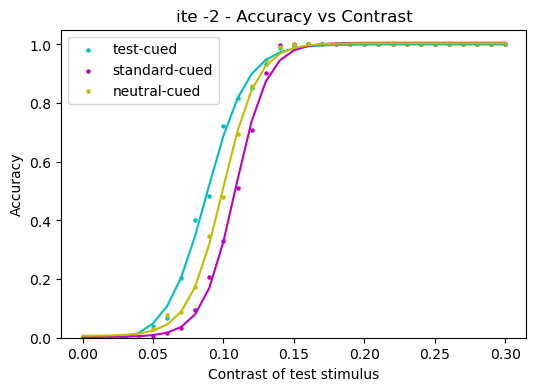

Params for test-cued n0 - i-1: [49.39092947  0.08978623  0.9533019   0.05397033]
Params for standard-cued n0 - i-1: [5.62793976e+01 1.10047231e-01 9.84363390e-01 2.62627562e-02]
Params for neutral-cued n0 - i-1: [7.96638430e+01 9.95031445e-02 9.98649804e-01 6.23223776e-03]


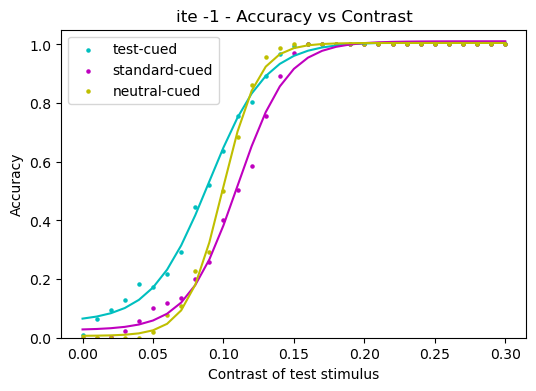

Params for test-cued n1 - i-2: [3.42677220e+01 8.83393115e-02 1.00495549e+00 6.24465381e-04]
Params for standard-cued n1 - i-2: [ 3.85114468e+01  1.09758367e-01  1.01238889e+00 -2.20075066e-03]
Params for neutral-cued n1 - i-2: [3.90958892e+01 1.01865603e-01 1.00363368e+00 4.16666483e-03]


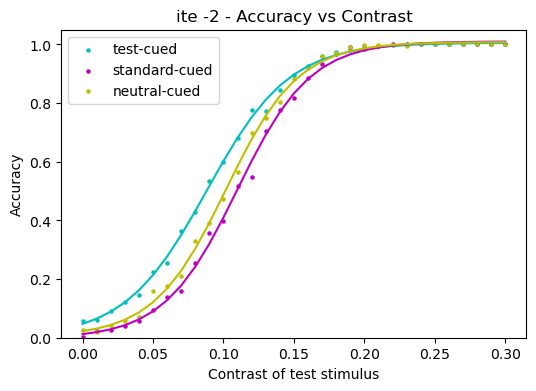

Params for test-cued n1 - i-1: [4.14480445e+01 8.97262791e-02 9.77373624e-01 3.08483548e-02]
Params for standard-cued n1 - i-1: [4.46104552e+01 1.10819306e-01 9.96395707e-01 1.22880697e-02]
Params for neutral-cued n1 - i-1: [4.99809275e+01 1.00043168e-01 9.98801294e-01 5.42162978e-03]


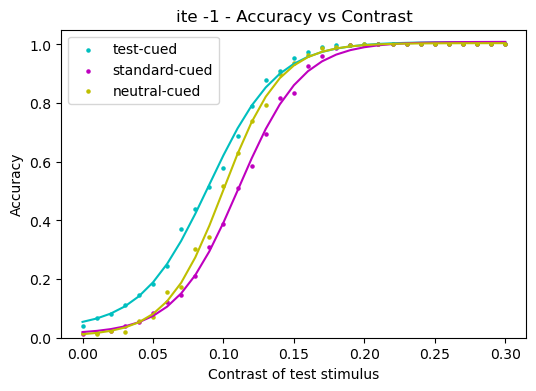

Params for test-cued n2 - i-2: [2.12840388e+01 9.91002892e-02 1.01211903e+00 1.99448262e-03]
Params for standard-cued n2 - i-2: [21.76479208  0.12549229  1.05543374 -0.02588756]
Params for neutral-cued n2 - i-2: [ 2.25652259e+01  1.14753211e-01  1.04539684e+00 -2.24487287e-02]


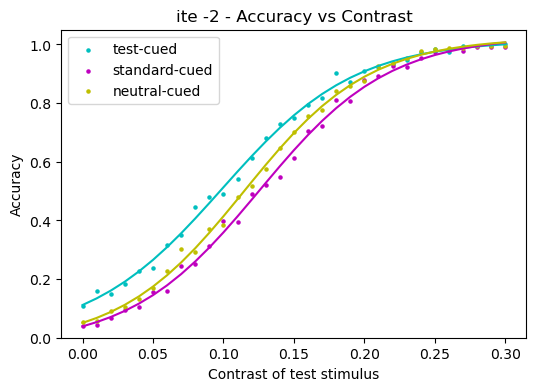

Params for test-cued n2 - i-1: [29.76981707  0.09806948  0.97593257  0.03588974]
Params for standard-cued n2 - i-1: [ 3.03373300e+01  1.15883628e-01  1.01571961e+00 -1.97718255e-03]
Params for neutral-cued n2 - i-1: [ 2.92934992e+01  1.06772818e-01  1.01618377e+00 -2.27083065e-03]


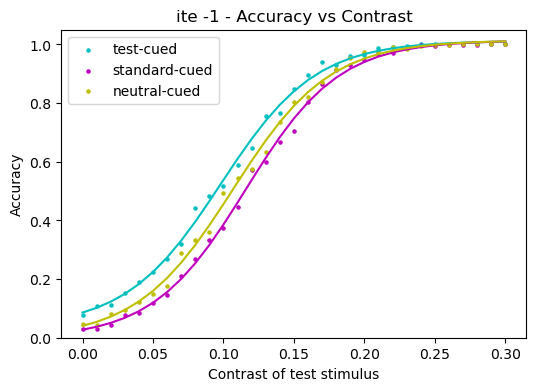

In [16]:
for n in range(len(noise_range)):
    x = torch.tensor(a_0_range)
    colors = ["c", "m", "y"]
    for i in (-2, -1):
        plt.figure(figsize=(6, 4))
        plt.scatter(a_0_range, acc_stuff[0, n, :, i], label=f"test-cued", color=colors[0], s=5)
        params = fit_sigmoid(x, acc_stuff[0, n, :, i])
        print(f"Params for test-cued n{n} - i{i}: {params}")
        y = sigmoid(x, *params)
        plt.plot(x, y, color=colors[0])
        plt.scatter(a_0_range, acc_stuff[1, n, :, i], label=f"standard-cued", color=colors[1], s=5)
        params = fit_sigmoid(x, acc_stuff[1, n, :, i])
        print(f"Params for standard-cued n{n} - i{i}: {params}")
        y = sigmoid(x, *params)
        plt.plot(x, y, color=colors[1])
        plt.scatter(a_0_range, acc_stuff[2, n, :, i], label=f"neutral-cued", color=colors[2], s=5)
        params = fit_sigmoid(x, acc_stuff[2, n, :, i])
        print(f"Params for neutral-cued n{n} - i{i}: {params}")
        y = sigmoid(x, *params)
        plt.plot(x, y, color=colors[2])
        plt.ylim(0.0, 1.05)
        plt.xlabel("Contrast of test stimulus")
        plt.ylabel("Accuracy")
        plt.title(f"ite {i} - Accuracy vs Contrast")
        plt.legend()
        plt.savefig(os.path.join(results_folder, f"s_ite{i}_noise{noise_range[n]}_acc_vs_contrast.svg"), format="svg")
        plt.show()
    

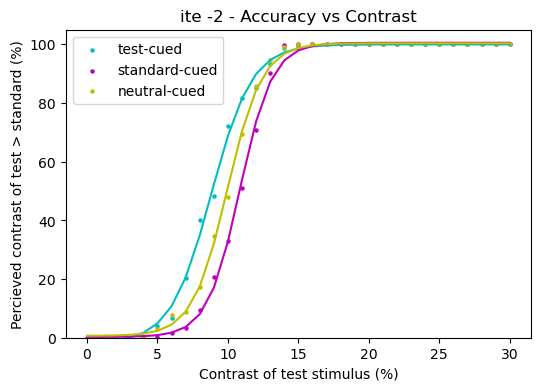

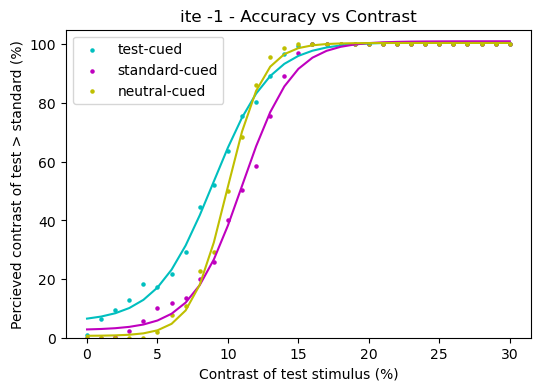

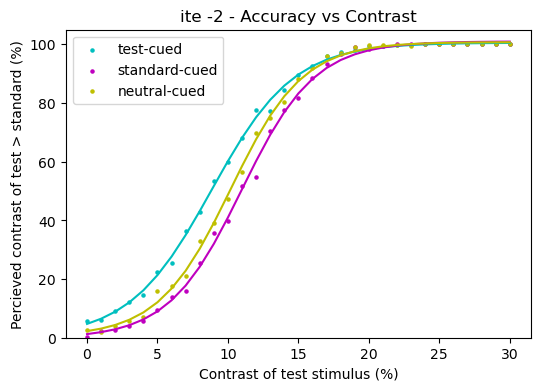

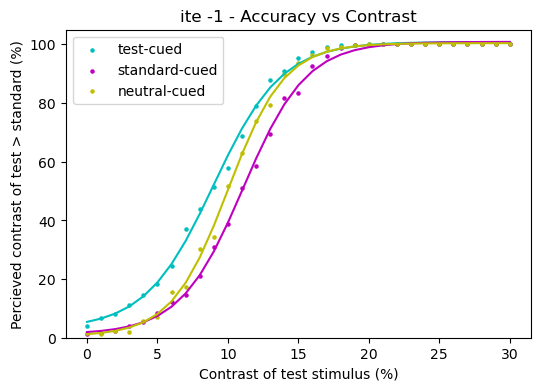

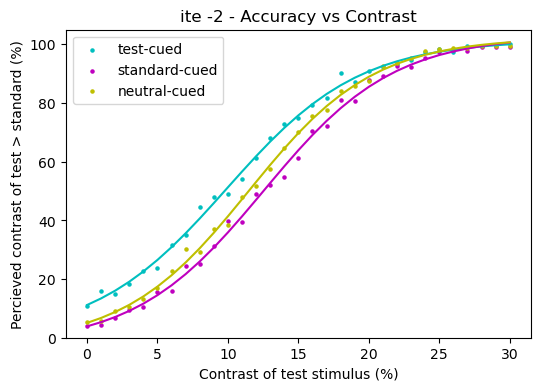

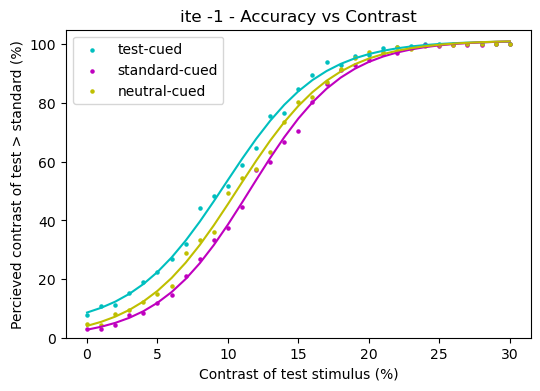

In [17]:
n = 0
for n in range(len(noise_range)):
    x = torch.tensor(a_0_range)
    colors = ["c", "m", "y"]
    for i in (-2, -1):
        plt.figure(figsize=(6, 4))
        plt.scatter(x*100, 100*acc_stuff[0, n, :, i], label=f"test-cued", color=colors[0], s=5)
        plt.plot(x*100, 100*sigmoid(x, *fit_sigmoid(x, acc_stuff[0, n, :, i])), color=colors[0])
        plt.scatter(x*100, 100*acc_stuff[1, n, :, i], label=f"standard-cued", color=colors[1], s=5)
        plt.plot(x*100, 100*sigmoid(x, *fit_sigmoid(x, acc_stuff[1, n, :, i])), color=colors[1])
        plt.scatter(x*100, 100*acc_stuff[2, n, :, i], label=f"neutral-cued", color=colors[2], s=5)
        plt.plot(x*100, 100*sigmoid(x, *fit_sigmoid(x, acc_stuff[2, n, :, i])), color=colors[2])
        plt.ylim(0, 105)
        plt.xlabel("Contrast of test stimulus (%)")
        plt.ylabel("Percieved contrast of test > standard (%)")
        plt.title(f"ite {i} - Accuracy vs Contrast")
        plt.legend()
        plt.savefig(os.path.join(results_folder, f"s_ite{i}_noise{noise_range[n]}_acc_vs_contrast.svg"), format="svg")
        plt.show()
    